**Data 620 Project 3**

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can.

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

In [76]:
#import packages required
import nltk
from nltk.corpus import names
import random

**Load dataset**

The `names` dataset is built into the `nltk` package:

In [77]:
#check the corpus, there are two files, female.txt and male.txt
names = nltk.corpus.names
names.fileids()

['female.txt', 'male.txt']

Let us run some diagnostics first on the names to get familiar about the distributions.

We see that more female names start with the first letters A, C, M and S. 

The last names do follow what is set in the textbook, names ending in A, E and I tend to be female. However, names ending in L, N and S tend to be male here, whereas the textbook in section 2.4 finds that names ending in K, O, R, S and T tend to be male.

The distributions seem uneven, there seems to be more female names than males.

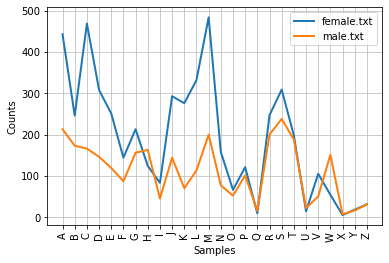

In [78]:
#Check distribution for first letter of name
gender_freq = nltk.ConditionalFreqDist((fileid, name[0])
    for fileid in names.fileids()
    for name in names.words(fileid))
gender_freq.plot()


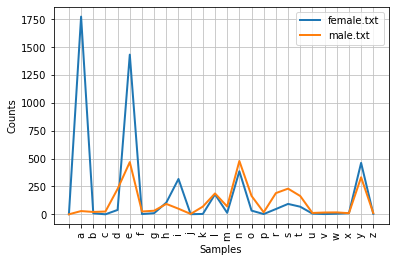

In [79]:
#Check distribution for last letter of name
gender_freq = nltk.ConditionalFreqDist((fileid, name[-1])
    for fileid in names.fileids()
    for name in names.words(fileid))
gender_freq.plot()

**Data Cleaning and Exploration**

We will first merge the two text files and shuffle them. We then divide as follows:

**Development set:**

6944 names for the training (train_names)
500 names for the testing (devtest_names)

**Test set:**

500 names for the testing (test_names)
The training set is used to train the model, and the dev-test set is used to perform error analysis. The test set serves in our final evaluation of the model.

In [80]:
#Merge the two text files and shuffle
names = ([(name, 'male') for name in nltk.corpus.names.words('male.txt')] + 
        [(name, 'female') for name in nltk.corpus.names.words('female.txt')])

random.seed(1804)
random.shuffle(names)
names[1:10]

[('Antonetta', 'female'),
 ('Roana', 'female'),
 ('Tarrah', 'female'),
 ('Leoine', 'female'),
 ('Rab', 'male'),
 ('Waldo', 'male'),
 ('Nelia', 'female'),
 ('Ardra', 'female'),
 ('Jud', 'male')]

In [81]:
test=names[0:500]
devtest=names[500:1000]
train=names[1000:]

# Confirm the size of the three subsets
print("Training Set = {}".format(len(train)))
print("Dev-Test Set = {}".format(len(devtest)))
print("Test Set = {}".format(len(test)))

Training Set = 6944
Dev-Test Set = 500
Test Set = 500


In [82]:
#Check the distribution of females vs males in the train dataset
train_dist = [g  for (n, g) in train]
nltk.FreqDist(train_dist)

#As expected there are a lot more female names than male names in the dataset.

FreqDist({'female': 4368, 'male': 2576})

**Classify using Naive Bayes**

Testing features

**Feature 1**

**First vs Last Letter**

We will test whether using first letter or last letter gives us a better accuracy. We can see using the last letter increases accuracy of both the datasets.

In [83]:
#Feature 1 first letter
def first_letter(name):
    name=name.lower()
    return {
        'first_1_letter': name[0]
        }
first_letter("Mary")

{'first_1_letter': 'm'}

In [84]:
train_set = [(first_letter(n), g) for (n,g) in train]
devtest_set = [(first_letter(n), g) for (n,g) in devtest]
test_set = [(first_letter(n), g) for (n,g) in test]
nb = nltk.NaiveBayesClassifier.train(train_set) 
print('Devset accuracy is')
print(nltk.classify.accuracy(nb, devtest_set))
print('Test accuracy is')
print(nltk.classify.accuracy(nb, test_set))

Devset accuracy is
0.648
Test accuracy is
0.652


In [85]:
#Looking at the most informative features
classifier = nltk.NaiveBayesClassifier.train(train_set)
classifier.show_most_informative_features(10) 

Most Informative Features
          first_1_letter = 'w'              male : female =      4.9 : 1.0
          first_1_letter = 'q'              male : female =      3.0 : 1.0
          first_1_letter = 'u'              male : female =      2.4 : 1.0
          first_1_letter = 'k'            female : male   =      2.2 : 1.0
          first_1_letter = 'h'              male : female =      2.2 : 1.0
          first_1_letter = 'x'              male : female =      2.1 : 1.0
          first_1_letter = 'l'            female : male   =      1.7 : 1.0
          first_1_letter = 'c'            female : male   =      1.7 : 1.0
          first_1_letter = 't'              male : female =      1.6 : 1.0
          first_1_letter = 'y'              male : female =      1.6 : 1.0


In [86]:
#Feature 2 last letter
def last_letter(name):
    name=name.lower()
    return {
        'last_1_letter': name[-1]
        }
last_letter("Mary")

{'last_1_letter': 'y'}

In [87]:
train_set = [(last_letter(n), g) for (n,g) in train]
devtest_set = [(last_letter(n), g) for (n,g) in devtest]
test_set = [(last_letter(n), g) for (n,g) in test]
nb = nltk.NaiveBayesClassifier.train(train_set) 
print('Devset accuracy is')
print(nltk.classify.accuracy(nb, devtest_set))
print('Test accuracy is')
print(nltk.classify.accuracy(nb, test_set))

Devset accuracy is
0.76
Test accuracy is
0.754


In [88]:
#Looking at the most informative features
classifier = nltk.NaiveBayesClassifier.train(train_set)
classifier.show_most_informative_features(10) 

Most Informative Features
           last_1_letter = 'a'            female : male   =     32.4 : 1.0
           last_1_letter = 'k'              male : female =     29.7 : 1.0
           last_1_letter = 'v'              male : female =     16.4 : 1.0
           last_1_letter = 'f'              male : female =     13.9 : 1.0
           last_1_letter = 'm'              male : female =     10.1 : 1.0
           last_1_letter = 'p'              male : female =      9.8 : 1.0
           last_1_letter = 'd'              male : female =      9.7 : 1.0
           last_1_letter = 'o'              male : female =      8.9 : 1.0
           last_1_letter = 'r'              male : female =      6.9 : 1.0
           last_1_letter = 'z'              male : female =      5.8 : 1.0


**Feature 2**

**Last 2 letters**

We see that using last 2 letters improves the accuracy of both devtest and test.

In [89]:
def last_2_letters(name):
    name=name.lower()
    return {
        'last_2_letters': name[-2:]
        }
last_2_letters("Andy")

{'last_2_letters': 'dy'}

In [90]:
train_set = [(last_2_letters(n), g) for (n,g) in train]
devtest_set = [(last_2_letters(n), g) for (n,g) in devtest]
test_set = [(last_2_letters(n), g) for (n,g) in test]
nb = nltk.NaiveBayesClassifier.train(train_set) 
print('Devset accuracy is')
print(nltk.classify.accuracy(nb, devtest_set))
print('Test accuracy is')
print(nltk.classify.accuracy(nb, test_set))

Devset accuracy is
0.786
Test accuracy is
0.792


In [91]:
#Looking at the most informative features
classifier = nltk.NaiveBayesClassifier.train(train_set)
classifier.show_most_informative_features(10) 

Most Informative Features
          last_2_letters = 'na'           female : male   =     93.2 : 1.0
          last_2_letters = 'la'           female : male   =     73.6 : 1.0
          last_2_letters = 'ia'           female : male   =     38.1 : 1.0
          last_2_letters = 'sa'           female : male   =     35.1 : 1.0
          last_2_letters = 'ra'           female : male   =     34.8 : 1.0
          last_2_letters = 'io'             male : female =     24.9 : 1.0
          last_2_letters = 'us'             male : female =     24.0 : 1.0
          last_2_letters = 'ta'           female : male   =     23.1 : 1.0
          last_2_letters = 'do'             male : female =     22.7 : 1.0
          last_2_letters = 'rd'             male : female =     22.7 : 1.0


Feature 3
**2 letters as suffix + last trigram +first trigram + first fourgram**

In [92]:
def feature3(name):
        name=name.lower()
        return {
            'suffix1': name[-1:],
            'suffix2': name[-2:],
            'last_trigram': name[-3:],
            'first_trigram': name[:3], 
            'first_fourgram': name[:4]
               }
feature3("Mademoiselle")

{'suffix1': 'e',
 'suffix2': 'le',
 'last_trigram': 'lle',
 'first_trigram': 'mad',
 'first_fourgram': 'made'}

In [93]:
train_set = [(feature3(n), g) for (n,g) in train]
devtest_set = [(feature3(n), g) for (n,g) in devtest]
test_set = [(feature3(n), g) for (n,g) in test]
nb = nltk.NaiveBayesClassifier.train(train_set) 
print('Devset accuracy is')
print(nltk.classify.accuracy(nb, devtest_set))
print('Test accuracy is')
print(nltk.classify.accuracy(nb, test_set))

Devset accuracy is
0.846
Test accuracy is
0.868


## Features 4,5,6

### Additional Feature Engineering Based off of this work: 
https://arxiv.org/pdf/1606.05467.pdf

### In this feature generation instead of just looking the prescence and count of every character instead I opted to group characters by Kiki and Bouba characters which are groupings of letters based off the way they are pronounced

### I found some interesting reading on Bouba vs Kiki as well
https://en.wikipedia.org/wiki/Bouba/kiki_effect
https://www.scientificamerican.com/article/bring-science-home-bouba-kiki-effect/

### In the feature engineering below I aslo brought in the syllable count as well

In [94]:
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count


In [95]:
def feature6(name):
        name=name.lower()
        return {
            'suffix1': name[-1:],
            'suffix2': name[-2:],
            'last_trigram': name[-3:],
            'first_trigram': name[:3], 
            'first_fourgram': name[:4],
            'bouba_letters': len([v for v in name if v in 'blmnuo']),
            'kiki_letters':len([v for v in name if v in 'kptiezv']),
            'syllable_count':syllable_count(name)
            
               }
feature6("Mademoiselle")

{'suffix1': 'e',
 'suffix2': 'le',
 'last_trigram': 'lle',
 'first_trigram': 'mad',
 'first_fourgram': 'made',
 'bouba_letters': 5,
 'kiki_letters': 4,
 'syllable_count': 4}

In [96]:
train_set = [(feature6(n), g) for (n,g) in train]
devtest_set = [(feature6(n), g) for (n,g) in devtest]
test_set = [(feature6(n), g) for (n,g) in test]
nb = nltk.NaiveBayesClassifier.train(train_set) 
print('Devset accuracy is')
print(nltk.classify.accuracy(nb, devtest_set))
print('Test accuracy is')
print(nltk.classify.accuracy(nb, test_set))

Devset accuracy is
0.86
Test accuracy is
0.868


In [97]:
nb.show_most_informative_features(500)

Most Informative Features
                 suffix2 = 'na'           female : male   =     93.2 : 1.0
                 suffix2 = 'la'           female : male   =     73.6 : 1.0
                 suffix2 = 'ia'           female : male   =     38.1 : 1.0
                 suffix2 = 'sa'           female : male   =     35.1 : 1.0
                 suffix2 = 'ra'           female : male   =     34.8 : 1.0
                 suffix1 = 'a'            female : male   =     32.4 : 1.0
                 suffix1 = 'k'              male : female =     29.7 : 1.0
                 suffix2 = 'io'             male : female =     24.9 : 1.0
            last_trigram = 'tta'          female : male   =     24.3 : 1.0
                 suffix2 = 'us'             male : female =     24.0 : 1.0
                 suffix2 = 'ta'           female : male   =     23.1 : 1.0
                 suffix2 = 'do'             male : female =     22.7 : 1.0
                 suffix2 = 'rd'             male : female =     22.7 : 1.0